In [8]:
#load libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
# text/file processing libraries
import string
import re
import sys
from nltk.corpus import stopwords
from itertools import chain
# warnings
import string
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from nltk.tokenize import word_tokenize

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [11]:
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:

train_df=pd.read_csv("train.csv")
train_df

,ID,Review,Rating
0,0,exceptional service nice all-around daughter s...,5
1,1,beautiful relaxing jw marriott desert ridge re...,5
2,2,great location great location 5 mins subway ta...,5
3,3,"pleased nice safe hotel, flower market hotel v...",3
4,4,excellent hotel service great hotel excellent ...,4
...,...,...,...
14338,14338,"hotel madrid hotel perfect, location tiny quie...",5
14339,14339,excellent hotel stay florence hotel chosen tri...,5
14340,14340,great place relax know looking vacation book t...,4
14341,14341,"better just got week seattle loved minute, pac...",3


In [6]:

test_df=pd.read_csv("test.csv")
test_df

,ID,Review
0,0,just superb rendezvous just perfect property s...
1,1,"better close staten island ferry easy subway, ..."
2,2,"enjoyed stay, just come long weekend barcelona..."
3,3,"muse great, muse hotel great, did n't hear noi..."
4,4,"conveniently located morning flight, family st..."
...,...,...
6143,6143,great hotel precruise great hotel arrived earl...
6144,6144,great choice just returned nights grand hotel ...
6145,6145,overpriced tiny rooms kowloon past use date ne...
6146,6146,"ok, agree said positive staff helpful rooms cl..."


In [7]:
stop=pd.read_pickle("stp_wrds.pkl")

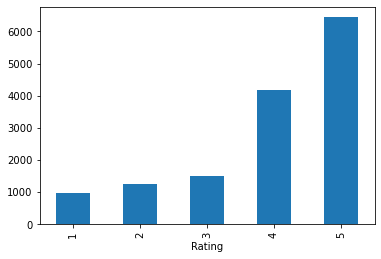

In [13]:
rating_count=train_df.groupby(by='Rating').ID.count()
rating_count.plot.bar()
plt.show()

In [14]:
train_df.groupby(by='Rating').ID.count()

Rating
1     977
2    1248
3    1510
4    4172
5    6436
Name: ID, dtype: int64

In [19]:
#Remove html links and entity references
def html_references(texts):
    texts = texts
    # remove url - references to websites
    url_remove  = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    texts  = re.sub(url_remove, '', texts)
    # remove common html entity references in utf-8 as '&lt;', '&gt;', '&amp;'
    entities_remove = r'&amp;|&gt;|&lt'
    texts = re.sub(entities_remove, "", texts)
    # split into words by white space
    words = texts.split()
    #convert to lower case
    words = [word.lower() for word in words]
    return " ".join(words)
train_df['Review'] = train_df['Review'].apply(lambda x : html_references(x))
test_df['Review'] = test_df['Review'].apply(lambda x : html_references(x))

In [20]:
def decontraction(text):
    # specific
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 
train_df['Review'] = train_df['Review'].apply(lambda x : decontraction(x))
test_df['Review'] = test_df['Review'].apply(lambda x : decontraction(x))

In [21]:
#remove punctuation
def filter_punctuations_etc(texts):
    words = texts.split()
    # prepare regex for char filtering
    re_punc = re.compile( '[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    words = [re_punc.sub('', w) for w in words]
    # filter out non-printable characters
    re_print = re.compile( '[^%s]' % re.escape(string.printable))
    words = [re_print.sub(' ', w) for w in words]
    return " ".join(words)
train_df['Review'] = train_df['Review'].apply(lambda x : filter_punctuations_etc(x))
test_df['Review'] = test_df['Review'].apply(lambda x : filter_punctuations_etc(x))

In [22]:
def separate_alphanumeric(texts):
    words = texts
    # separate alphanumeric
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)
train_df['Review'] = train_df['Review'].apply(lambda x : separate_alphanumeric(x))
test_df['Review'] = test_df['Review'].apply(lambda x : separate_alphanumeric(x))

In [23]:
#Change repetitive characters
def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] # take max of 2 consecutive letters
def unique_char(rep, texts):
    substitute = re.sub(r'(\w)\1+', rep, texts)
    return substitute
train_df['Review'] = (train_df['Review'].astype('str').apply(lambda x : unique_char(cont_rep_char, x)))
test_df['Review'] = (test_df['Review'].astype('str').apply(lambda x : unique_char(cont_rep_char, x)))

In [24]:
!pip install wordninja

  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541558 sha256=796a801a5bf0eed9e983ef7b00fee843769fde48ad64aed62d39baf10b2ada14
  Stored in directory: c:\users\sathi\appdata\local\pip\cache\wheels\dd\3f\eb\a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja


In [25]:
import wordninja # !pip install wordninja
def split_attached_words(text):
    words = wordninja.split(text)
    return" ".join(words)
train_df['Review'] = train_df['Review'].apply(lambda x : split_attached_words(x))
test_df['Review'] = test_df['Review'].apply(lambda x : split_attached_words(x))

In [26]:
def stopwords_shortwords(text):
    # filter out stop words
    words = text.split()
    stop_words = set(stopwords.words( 'english' ))
    words = [w for w in words if not w in stop_words]
    # filter out short tokens
    for word in words:
        if word.isalpha():
            words = [word for word in words if len(word) > 1 ]
        else:
            words = [word for word in words]
    return" ".join(words)
train_df['Review'] = train_df['Review'].apply(lambda x : stopwords_shortwords(x))
test_df['Review'] = test_df['Review'].apply(lambda x : stopwords_shortwords(x))

In [52]:
!pip install pyspellchecker

In [28]:
df=pd.concat([train_df,test_df])
df.shape

(20491, 4)

In [8]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [54]:
df['Review']=df['Review'].apply(lambda x : correct_spellings(x))

In [55]:
#create a pickle file for df
with open("df.pkl", "wb") as picklefile:
         pickle.dump(df, picklefile)

In [9]:
new_df=df[["Review","Rating"]]

# WORD EMBEDDING USING ONE HOT

In [26]:
text = new_df['Review'].tolist()
text[:10]

['exceptional service nice around daughter stayed well priced hotel 99 night king suite weekend nights really impressed exceptionally welcoming service time reservation departure hotel employee talked really friendly eager help questions amazed day age shaped hotel pool tiny looked like fun kids hot tub exercise room well breakfast abundant make waffles add scrambled eggs bacon sausage fruit available bagels muffins oatmeal yogurt wanted morning sort long line waiting make waffles waiting scrambled eggs pick room really nice asked away freeway reading reviews earlier bit noisy hey city felt like deluxe room considering reasonable price nice bedding art walls really liked space needle bit window shuttle runs hourly reserve certain place certain time worked shuttle missed minute needed return space needle promptly paid cab fare asked definitely need stay near downtown seattle',
 'beautiful relaxing marriott desert ridge resort outstanding accommodation business pleasure husband stayed bu

In [27]:
token = Tokenizer()
token.fit_on_texts(text)
token

In [28]:
corpus=text
from nltk.tokenize import word_tokenize

all_words = []
for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [29]:
unique_words = set(all_words)
print(len(unique_words))

30120


In [30]:
#set vocabulary size
vocab_size = len(unique_words) + 1
vocab_size

30121

In [31]:
embedded_sentences = [one_hot(sent, vocab_size) for sent in corpus]
print(embedded_sentences )

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [33]:
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences)

[[18195 19502 13220 ...     0     0     0]
 [26380 18349  5289 ...     0     0     0]
 [16954 10025 16954 ...     0     0     0]
 ...
 [17044 11669  2565 ...     0     0     0]
 [28171  5409 15423 ...     0     0     0]
 [16954 10025  8318 ...     0     0     0]]


In [34]:
vect_size=300
model=Sequential()
model.add(Embedding(vocab_size,vect_size,input_length=length_long_sentence))
#model.add(GRU(units=32,dropout=0.2,recurrent_dropout=0.2))



model.add(Conv1D(64, 8, activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(30, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(6, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [40]:
train=padded_sentences[:train_df.shape[0]]
test=padded_sentences[train_df.shape[0]:]

In [41]:
X_train,X_test,y_train,y_test=train_test_split(train,train_df['Rating'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (12191, 1896)
Shape of Validation  (2152, 1896)


In [42]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [43]:
%%time
Embed_model=model.fit(X_train, y_train, epochs = 10, validation_split = 0.2,verbose=2,batch_size=128)

Train on 9752 samples, validate on 2439 samples
Epoch 1/10
9752/9752 - 318s - loss: 1.4602 - acc: 0.3977 - val_loss: 1.4357 - val_acc: 0.4502
Epoch 2/10
9752/9752 - 419s - loss: 1.3619 - acc: 0.4471 - val_loss: 1.4449 - val_acc: 0.4502
Epoch 3/10
9752/9752 - 397s - loss: 1.3573 - acc: 0.4470 - val_loss: 1.4355 - val_acc: 0.4502
Epoch 4/10
9752/9752 - 347s - loss: 1.3596 - acc: 0.4467 - val_loss: 1.4358 - val_acc: 0.4502
Epoch 5/10
9752/9752 - 313s - loss: 1.3579 - acc: 0.4469 - val_loss: 1.4448 - val_acc: 0.4502
Epoch 6/10
9752/9752 - 346s - loss: 1.3571 - acc: 0.4471 - val_loss: 1.4434 - val_acc: 0.4502
Epoch 7/10
9752/9752 - 347s - loss: 1.3580 - acc: 0.4471 - val_loss: 1.4310 - val_acc: 0.4502
Epoch 8/10
9752/9752 - 344s - loss: 1.3590 - acc: 0.4469 - val_loss: 1.4536 - val_acc: 0.4502
Epoch 9/10
9752/9752 - 333s - loss: 1.3583 - acc: 0.4471 - val_loss: 1.4406 - val_acc: 0.4502
Epoch 10/10
9752/9752 - 322s - loss: 1.3566 - acc: 0.4471 - val_loss: 1.4474 - val_acc: 0.4502
Wall time: 

In [78]:
score, acc = model.evaluate(X_test, y_test,
                       batch_size=128, verbose=2)

print('Test accuracy:', acc)

2152/2152 - 14s - loss: 1.2364 - acc: 0.5232
Test accuracy: 0.5232342


In [79]:
#Aplly test data and make pediction
y_pred=model.predict(test)
y_pred

array([[2.6001248e-06, 1.3662323e-07, 1.9371095e-05, 4.4283914e-04,
        2.3296194e-02, 9.7623891e-01],
       [6.1382730e-06, 1.7426689e-03, 5.4103110e-02, 4.2303586e-01,
        2.7700743e-01, 2.4410482e-01],
       [9.4806010e-06, 2.0867859e-05, 1.2283328e-03, 7.8137172e-03,
        9.9232741e-02, 8.9169490e-01],
       ...,
       [6.9960795e-04, 3.5259280e-01, 3.3373076e-01, 2.6717356e-01,
        3.9513327e-02, 6.2899091e-03],
       [6.5669685e-04, 9.3390152e-04, 1.3017022e-02, 1.8092790e-01,
        3.5425088e-01, 4.5021358e-01],
       [6.0453359e-04, 4.7071544e-03, 5.0290946e-02, 2.1185255e-01,
        3.5333773e-01, 3.7920710e-01]], dtype=float32)

In [80]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([5, 3, 5, ..., 1, 5, 5], dtype=int64)

# WORD EMBEDDING USING GLOVE

In [13]:
#glove vectorization
def create_corpus(df):
    corpus=[]
    for text in tqdm(df['Review']):
        words=[word.lower() for word in word_tokenize(text) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [14]:
corpus=create_corpus(df)

100%|██████████| 20491/20491 [00:36<00:00, 557.55it/s]


In [15]:
embedding_dict={}
with open('glove.6B.100d.txt','rb') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [16]:
MAX_LEN=150
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

review_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [17]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 27735


In [18]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 27735/27735 [00:00<00:00, 579345.11it/s]


In [19]:
from keras.initializers import Constant
from keras.layers import SpatialDropout1D
from keras.optimizers import Adam

Using TensorFlow backend.


In [20]:
glove_model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

glove_model.add(embedding)
glove_model.add(Dropout(0.5))
glove_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
glove_model.add(Dense(6, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
optimzer=Adam(learning_rate=1e-5)

glove_model.compile(loss='sparse_categorical_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [22]:
train=review_pad[:train_df.shape[0]]
test=review_pad[train_df.shape[0]:]

In [23]:
X_train,X_test,y_train,y_test=train_test_split(train,train_df['Rating'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (12191, 150)
Shape of Validation  (2152, 150)


In [24]:
history=glove_model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

Train on 12191 samples, validate on 2152 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
12191/12191 - 323s - loss: 1.5398 - acc: 0.4517 - val_loss: 1.4268 - val_acc: 0.4243
Epoch 2/10
12191/12191 - 295s - loss: 1.3742 - acc: 0.4529 - val_loss: 1.3931 - val_acc: 0.4243
Epoch 3/10
12191/12191 - 298s - loss: 1.3577 - acc: 0.4528 - val_loss: 1.3811 - val_acc: 0.4243
Epoch 4/10
12191/12191 - 319s - loss: 1.3536 - acc: 0.4530 - val_loss: 1.3801 - val_acc: 0.4243
Epoch 5/10
12191/12191 - 309s - loss: 1.3523 - acc: 0.4531 - val_loss: 1.3788 - val_acc: 0.4243
Epoch 6/10
12191/12191 - 320s - loss: 1.3514 - acc: 0.4532 - val_loss: 1.3783 - val_acc: 0.4243
Epoch 7/10
12191/12191 - 318s - loss: 1.3505 - acc: 0.4529 - val_loss: 1.3762 - val_acc: 0.4243
Epoch 8/10
12191/12191 - 320s - loss: 1.3502 - acc: 0.4530 - val_loss: 1.3773 - val_acc: 0.4243
Epoch 9/10
12191/12191 - 381s - loss: 1.3494 - acc: 0.4530 - val_loss: 1.3774 - val_acc: 

In [25]:
score, acc = glove_model.evaluate(X_test, y_test,
                       batch_size=128, verbose=2)

print('Test accuracy:', acc)

2152/2152 - 1s - loss: 1.3769 - acc: 0.4243
Test accuracy: 0.4242565


# model building using supervised machine learning algorithms

In [8]:
df=pd.read_pickle("df.pkl")

In [9]:
train1=df[:train_df.shape[0]]
test1=df[train_df.shape[0]:]

In [10]:
train1

,ID,Review,Rating,target_relabeled
0,0,exceptional service nice around daughter staye...,5.0,5.0
1,1,beautiful relaxing marriott desert ridge resor...,5.0,5.0
2,2,great location great location mins subway take...,5.0,5.0
3,3,pleased nice safe hotel flower market hotel va...,3.0,3.0
4,4,excellent hotel service great hotel excellent ...,4.0,4.0
...,...,...,...,...
14338,14338,hotel madrid hotel perfect location tiny quiet...,5.0,5.0
14339,14339,excellent hotel stay florence hotel chosen tri...,5.0,5.0
14340,14340,great place relax know looking vacation book t...,4.0,4.0
14341,14341,better got week seattle loved minute pacific p...,3.0,3.0


In [11]:
test1

,ID,Review,Rating,target_relabeled
0,0,superb rendezvous perfect property singapore f...,NaN,NaN
1,1,better close staten island ferry easy subway r...,NaN,NaN
2,2,enjoyed stay come long weekend barcelona staye...,NaN,NaN
3,3,muse great muse hotel great hear noise reviewe...,NaN,NaN
4,4,conveniently located morning flight family sta...,NaN,NaN
...,...,...,...,...
6143,6143,great hotel pre cruise great hotel arrived ear...,NaN,NaN
6144,6144,great choice returned nights grand hotel franc...,NaN,NaN
6145,6145,overpriced tiny rooms kowloon past use date ne...,NaN,NaN
6146,6146,ok agree said positive staff helpful rooms cle...,NaN,NaN


In [12]:
#splitting the data for trainung and testing : train data

In [13]:
X=train1['Review']
y=train1['Rating']


In [14]:
#split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10757,)
(3586,)
(10757,)
(3586,)


In [39]:
#Testing data
test_X=test1["Review"]
test_y=y[0:6148]

# Text Representation.Bag of word approach

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
stop=pd.read_pickle("stp_wrds.pkl")

In [49]:
vect=CountVectorizer(tokenizer=word_tokenize,stop_words=stop, max_df=0.75, lowercase=False, ngram_range=(1,2))
# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)

In [50]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<3586x549336 sparse matrix of type '<class 'numpy.int64'>'
	with 385262 stored elements in Compressed Sparse Row format>

# Model building: Train data

We will use the following four models:

Logistic Regression

(Multinomial) Naive Bayes

Linear Support Vector Machine

Xgboost

SGD classifier

Random Forest

In [95]:
def NB_Classifier_result(X, y,X_test,y_test):
    NB = MultinomialNB()
    NB.fit(X, y)
    prediction = NB.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print("NB Classifier result:")
    return 


In [96]:
def LG_Classifier_result(X, y,X_test,y_test):
    LG = LogisticRegression()
    LG.fit(X,y)
    prediction = LG.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" LG Classifier result:")
     
    return

In [97]:
def SVM_Classifier_result(X, y,X_test,y_test):
    SVM = LinearSVC()
    SVM.fit(X,y)
    prediction = SVM.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" SVM Classifier result:")
    return 

In [98]:
def XG_Classifier_result(X, y,X_test,y_test):
    XGB = XGBClassifier(objective='multi:softmax', n_estimators=100, learning_rate=0.3, max_depth=4, subsample=0.8, n_iter_no_change=2, verbosity=1)
    XGB.fit(X,y)
    prediction = XGB.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" XGB Classifier result:")
    return 

In [99]:
def SGD_Classifier_result(X, y,X_test,y_test):
    SGD = SGDClassifier(max_iter=1000, tol=0.01)
    SGD.fit(X,y)
    prediction = SGD.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" SGD Classifier result:")
    return 

In [100]:

def RF_Classifier_result(X, y,X_test,y_test):
    RF = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
    RF.fit(X,y)
    prediction = RF.predict(X_test)
    print(classification_report(prediction, y_test))
    print(metrics.accuracy_score(y_test,prediction))
    print(" RF Classifier result:")
    return

# Model bulding : Test data

In [81]:
def NB_Classifier_result(X, y,X_test,y_test):
    NB = MultinomialNB()
    NB.fit(X, y)
    prediction = NB.predict(X_test)
       
    print("NB Classifier test data Accuracy:")
    print(metrics.accuracy_score(y_test,prediction))
    return 

In [82]:
def LG_Classifier_result(X, y,X_test,y_test):
    LG = LogisticRegression()
    LG.fit(X,y)
    prediction = LG.predict(X_test)
    print(" LG Classifier Accuracy:")
    print(metrics.accuracy_score(y_test,prediction))
    
    return

In [83]:
def SVM_Classifier_result(X, y,X_test,y_test):
    SVM = LinearSVC()
    SVM.fit(X,y)
    prediction = SVM.predict(X_test)
    print(" SVM Classifier Accuracy:")
    print(metrics.accuracy_score(y_test,prediction))
    return 

In [84]:
def XG_Classifier_result(X, y,X_test,y_test):
    XGB = XGBClassifier(objective='multi:softmax', n_estimators=100, learning_rate=0.3, max_depth=4, subsample=0.8, n_iter_no_change=2, verbosity=1)
    XGB.fit(X,y)
    prediction = XGB.predict(X_test)
    print(" XGB Classifier Accuracy:")
    print(metrics.accuracy_score(y_test,prediction))
    return 

In [85]:
def SGD_Classifier_result(X, y,X_test,y_test):
    SGD = SGDClassifier(max_iter=1000, tol=0.01)
    SGD.fit(X,y)
    prediction = SGD.predict(X_test)
    print(" SGD Classifier Accuracy:")
    print(metrics.accuracy_score(y_test,prediction))
    return 

In [86]:
def RF_Classifier_result(X, y,X_test,y_test):
    RF = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
    RF.fit(X,y)
    prediction = RF.predict(X_test)
    print(" RF Classifier Accuracy:")
    print(metrics.accuracy_score(y_test,prediction))
    return

# Random Oversampling Imbalanced Datasets

How to improve the performance?

Re-sampling Dataset

To make our dataset balanced there are two ways to do so:

Under-sampling: Remove samples from over-represented classes ; use this if you have huge dataset

Over-sampling: Add more samples from under-represented classes; use this if you have small dataset
 


Random oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset.

RandomOverSampler

SMOTE



In [57]:
#smote
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(X_train_dtm, y_train)
print(X_sm.shape, y_sm.shape)

(14836, 549336) (14836,)


In [58]:
#Random oversampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train_dtm, y_train)
print(X_ros.shape, y_ros.shape)

(24075, 549336) (24075,)


In [59]:
#RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus= rus.fit_sample(X_train_dtm, y_train)
print(X_rus.shape, y_rus.shape)

(3680, 549336) (3680,)


In [60]:
#TomekLinks
from imblearn.under_sampling import TomekLinks

tl = TomekLinks('majority')
X_tl, y_tl = tl.fit_sample(X_train_dtm, y_train)

In [61]:
#SMOTETomek
from imblearn.combine import SMOTETomek

smt = SMOTETomek('auto')
X_smt, y_smt = smt.fit_sample(X_train_dtm, y_train)

# Pasing imbalanced data(bow)

In [38]:
print(NB_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(LG_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(SVM_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(XG_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(SGD_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))
print(RF_Classifier_result(X_train_dtm, y_train,X_test_dtm,y_test))

              precision    recall  f1-score   support

         1.0       0.02      1.00      0.05         6
         2.0       0.01      0.29      0.01         7
         3.0       0.00      0.00      0.00         0
         4.0       0.16      0.27      0.20       608
         5.0       0.97      0.53      0.69      2965

    accuracy                           0.49      3586
   macro avg       0.23      0.42      0.19      3586
weighted avg       0.83      0.49      0.60      3586

0.4860568878973787
NB Classifier result:
None
              precision    recall  f1-score   support

         1.0       0.59      0.59      0.59       244
         2.0       0.29      0.42      0.34       217
         3.0       0.27      0.41      0.32       253
         4.0       0.47      0.47      0.47      1022
         5.0       0.79      0.70      0.74      1850

    accuracy                           0.59      3586
   macro avg       0.48      0.52      0.49      3586
weighted avg       0.62      0.

In [68]:
#pass test  data and check the accuracy
# transform testing data (using fitted vocabulary) into a document-term matrix

X_test_data = vect.transform(test_X)
X_test_data

<6148x549336 sparse matrix of type '<class 'numpy.int64'>'
	with 644215 stored elements in Compressed Sparse Row format>

In [69]:
#Check the accuracy of test data
print(NB_Classifier_result(X_train_dtm, y_train,X_test_data,test_y))
print(LG_Classifier_result(X_train_dtm, y_train,X_test_data,test_y))
print(SVM_Classifier_result(X_train_dtm, y_train,X_test_data,test_y))
print(XG_Classifier_result(X_train_dtm, y_train,X_test_data,test_y))
print(SGD_Classifier_result(X_train_dtm, y_train,X_test_data,test_y))
print(RF_Classifier_result(X_train_dtm, y_train,X_test_data,test_y))

NB Classifier test data Accuracy:
0.4201366297983084
None
 LG Classifier Accuracy:
0.3282368249837345
None
 SVM Classifier Accuracy:
0.328562134027326
None
 XGB Classifier Accuracy:
0.3445022771633051
None
 SGD Classifier Accuracy:
0.32286922576447624
None
 RF Classifier Accuracy:
0.4386792452830189
None


# Building and evaluating a model using balanced data

# Passing SMOTE

In [39]:
print(NB_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(LG_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(SVM_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(XG_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(SGD_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))
print(RF_Classifier_result(X_sm, y_sm,X_test_dtm,y_test))

              precision    recall  f1-score   support

         1.0       0.23      0.92      0.37        61
         2.0       0.00      1.00      0.01         1
         3.0       0.00      0.00      0.00         0
         4.0       0.16      0.28      0.21       577
         5.0       0.97      0.53      0.69      2947

    accuracy                           0.50      3586
   macro avg       0.27      0.55      0.25      3586
weighted avg       0.83      0.50      0.60      3586

0.4997211377579476
NB Classifier result:
None
              precision    recall  f1-score   support

         1.0       0.64      0.45      0.53       341
         2.0       0.28      0.41      0.33       213
         3.0       0.28      0.42      0.34       256
         4.0       0.47      0.49      0.48       974
         5.0       0.79      0.71      0.75      1802

    accuracy                           0.59      3586
   macro avg       0.49      0.50      0.49      3586
weighted avg       0.62      0.

In [70]:
#accuracy of test data
print(NB_Classifier_result(X_sm, y_sm,X_test_data,test_y))
print(LG_Classifier_result(X_sm, y_sm,X_test_data,test_y))
print(SVM_Classifier_result(X_sm, y_sm,X_test_data,test_y))
print(XG_Classifier_result(X_sm, y_sm,X_test_data,test_y))
print(SGD_Classifier_result(X_sm, y_sm,X_test_data,test_y))
print(RF_Classifier_result(X_sm, y_sm,X_test_data,test_y))

NB Classifier test data Accuracy:
0.41672088484059855
None
 LG Classifier Accuracy:
0.3217306441119063
None
 SVM Classifier Accuracy:
0.3160377358490566
None
 XGB Classifier Accuracy:
0.3441769681197137
None
 SGD Classifier Accuracy:
0.32075471698113206
None
 RF Classifier Accuracy:
0.41135328562134027
None


# Passing Random over sampler

In [165]:
print(NB_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(LG_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(SVM_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(XG_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(SGD_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))
print(RF_Classifier_result(X_ros, y_ros,X_test_dtm,y_test))

NB Classifier result:
              precision    recall  f1-score   support

           1       0.59      0.52      0.55       270
           2       0.38      0.33      0.35       368
           3       0.34      0.35      0.34       353
           4       0.36      0.55      0.43       671
           5       0.81      0.66      0.73      1622

    accuracy                           0.56      3284
   macro avg       0.49      0.48      0.48      3284
weighted avg       0.60      0.56      0.57      3284

0.5566382460414129
(0.5566382460414129, '              precision    recall  f1-score   support\n\n           1       0.59      0.52      0.55       270\n           2       0.38      0.33      0.35       368\n           3       0.34      0.35      0.34       353\n           4       0.36      0.55      0.43       671\n           5       0.81      0.66      0.73      1622\n\n    accuracy                           0.56      3284\n   macro avg       0.49      0.48      0.48      3284\nweig

C:\Users\sathi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


 LG Classifier result:
              precision    recall  f1-score   support

           1       0.58      0.57      0.57       244
           2       0.34      0.34      0.34       321
           3       0.35      0.30      0.32       417
           4       0.47      0.51      0.49       959
           5       0.71      0.70      0.71      1343

    accuracy                           0.55      3284
   macro avg       0.49      0.48      0.49      3284
weighted avg       0.55      0.55      0.55      3284

0.5493300852618758
(0.5493300852618758, '              precision    recall  f1-score   support\n\n           1       0.58      0.57      0.57       244\n           2       0.34      0.34      0.34       321\n           3       0.35      0.30      0.32       417\n           4       0.47      0.51      0.49       959\n           5       0.71      0.70      0.71      1343\n\n    accuracy                           0.55      3284\n   macro avg       0.49      0.48      0.49      3284\nwei

C:\Users\sathi\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 SVM Classifier result:
              precision    recall  f1-score   support

           1       0.42      0.49      0.45       205
           2       0.28      0.30      0.29       294
           3       0.30      0.27      0.28       396
           4       0.44      0.45      0.45      1014
           5       0.68      0.66      0.67      1375

    accuracy                           0.51      3284
   macro avg       0.42      0.43      0.43      3284
weighted avg       0.51      0.51      0.51      3284

0.5054811205846529
(0.5054811205846529, '              precision    recall  f1-score   support\n\n           1       0.42      0.49      0.45       205\n           2       0.28      0.30      0.29       294\n           3       0.30      0.27      0.28       396\n           4       0.44      0.45      0.45      1014\n           5       0.68      0.66      0.67      1375\n\n    accuracy                           0.51      3284\n   macro avg       0.42      0.43      0.43      3284\nwe

In [ ]:
Logistic Regression :0.5493300852618758

(Multinomial) Naive Bayes : 0.5566382460414129

Linear Support Vector Machine : 0.5054811205846529

Xgboost : 0.567904993909866

SGD classifier : 0.5292326431181485

Random Forest :  0.5828258221680876

# passing test data

In [71]:
print(NB_Classifier_result(X_ros, y_ros,X_test_data,test_y))
print(LG_Classifier_result(X_ros, y_ros,X_test_data,test_y))
print(SVM_Classifier_result(X_ros, y_ros,X_test_data,test_y))
print(XG_Classifier_result(X_ros, y_ros,X_test_data,test_y))
print(SGD_Classifier_result(X_ros, y_ros,X_test_data,test_y))
print(RF_Classifier_result(X_ros, y_ros,X_test_data,test_y))

NB Classifier test data Accuracy:
0.31766428106701367
None
 LG Classifier Accuracy:
0.31994144437215355
None
 SVM Classifier Accuracy:
0.3270982433311646
None
 XGB Classifier Accuracy:
0.29277813923227064
None
 SGD Classifier Accuracy:
0.3321405335068315
None
 RF Classifier Accuracy:
0.3767078724788549
None


# passing Random under sampler

In [167]:
print(NB_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(LG_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(SVM_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(XG_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(SGD_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))
print(RF_Classifier_result(X_rus, y_rus,X_test_dtm,y_test))

NB Classifier result:
              precision    recall  f1-score   support

           1       0.68      0.50      0.58       327
           2       0.35      0.29      0.32       370
           3       0.37      0.29      0.32       468
           4       0.30      0.51      0.38       614
           5       0.75      0.66      0.70      1505

    accuracy                           0.52      3284
   macro avg       0.49      0.45      0.46      3284
weighted avg       0.56      0.52      0.53      3284

0.5225334957369062
(0.5225334957369062, '              precision    recall  f1-score   support\n\n           1       0.68      0.50      0.58       327\n           2       0.35      0.29      0.32       370\n           3       0.37      0.29      0.32       468\n           4       0.30      0.51      0.38       614\n           5       0.75      0.66      0.70      1505\n\n    accuracy                           0.52      3284\n   macro avg       0.49      0.45      0.46      3284\nweig

C:\Users\sathi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


 LG Classifier result:
              precision    recall  f1-score   support

           1       0.62      0.51      0.56       293
           2       0.36      0.30      0.33       371
           3       0.39      0.27      0.32       538
           4       0.43      0.51      0.47       868
           5       0.66      0.72      0.69      1214

    accuracy                           0.53      3284
   macro avg       0.49      0.46      0.47      3284
weighted avg       0.52      0.53      0.52      3284

0.52557856272838
(0.52557856272838, '              precision    recall  f1-score   support\n\n           1       0.62      0.51      0.56       293\n           2       0.36      0.30      0.33       371\n           3       0.39      0.27      0.32       538\n           4       0.43      0.51      0.47       868\n           5       0.66      0.72      0.69      1214\n\n    accuracy                           0.53      3284\n   macro avg       0.49      0.46      0.47      3284\nweighte

Logistic Regression : 0.52557856272838

(Multinomial) Naive Bayes :0.5225334957369062

Linear Support Vector Machine : 0.48629719853836784

Xgboost : 0.5274056029232643

SGD classifier : 0.4826431181485993

Random Forest :  0.5289281364190013

# Passing test data

In [72]:
print(NB_Classifier_result(X_rus, y_rus,X_test_data,test_y))
print(LG_Classifier_result(X_rus, y_rus,X_test_data,test_y))
print(SVM_Classifier_result(X_rus, y_rus,X_test_data,test_y))
print(XG_Classifier_result(X_rus, y_rus,X_test_data,test_y))
print(SGD_Classifier_result(X_rus, y_rus,X_test_data,test_y))
print(RF_Classifier_result(X_rus, y_rus,X_test_data,test_y))

NB Classifier test data Accuracy:
0.24105400130123616
None
 LG Classifier Accuracy:
0.2797657774886142
None
 SVM Classifier Accuracy:
0.27683799609629145
None
 XGB Classifier Accuracy:
0.2691932335718933
None
 SGD Classifier Accuracy:
0.27765126870527
None
 RF Classifier Accuracy:
0.28871177618737803
None


# TomekLinks


In [169]:
print(NB_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(LG_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(SVM_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(XG_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(SGD_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))
print(RF_Classifier_result(X_tl,y_tl,X_test_dtm,y_test))

NB Classifier result:
              precision    recall  f1-score   support

           1       0.64      0.52      0.57       291
           2       0.34      0.33      0.34       330
           3       0.28      0.36      0.31       285
           4       0.38      0.54      0.44       720
           5       0.81      0.65      0.72      1658

    accuracy                           0.56      3284
   macro avg       0.49      0.48      0.48      3284
weighted avg       0.61      0.56      0.57      3284

0.557551766138855
(0.557551766138855, '              precision    recall  f1-score   support\n\n           1       0.64      0.52      0.57       291\n           2       0.34      0.33      0.34       330\n           3       0.28      0.36      0.31       285\n           4       0.38      0.54      0.44       720\n           5       0.81      0.65      0.72      1658\n\n    accuracy                           0.56      3284\n   macro avg       0.49      0.48      0.48      3284\nweight

C:\Users\sathi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


 LG Classifier result:
              precision    recall  f1-score   support

           1       0.54      0.57      0.56       229
           2       0.31      0.35      0.32       278
           3       0.31      0.32      0.32       354
           4       0.50      0.51      0.50      1020
           5       0.73      0.69      0.71      1403

    accuracy                           0.56      3284
   macro avg       0.48      0.49      0.48      3284
weighted avg       0.56      0.56      0.56      3284

0.5554202192448234
(0.5554202192448234, '              precision    recall  f1-score   support\n\n           1       0.54      0.57      0.56       229\n           2       0.31      0.35      0.32       278\n           3       0.31      0.32      0.32       354\n           4       0.50      0.51      0.50      1020\n           5       0.73      0.69      0.71      1403\n\n    accuracy                           0.56      3284\n   macro avg       0.48      0.49      0.48      3284\nwei

C:\Users\sathi\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 SVM Classifier result:
              precision    recall  f1-score   support

           1       0.43      0.49      0.46       207
           2       0.26      0.30      0.28       275
           3       0.28      0.27      0.27       371
           4       0.46      0.45      0.46      1047
           5       0.68      0.66      0.67      1384

    accuracy                           0.51      3284
   macro avg       0.42      0.44      0.43      3284
weighted avg       0.51      0.51      0.51      3284

0.5079171741778319
(0.5079171741778319, '              precision    recall  f1-score   support\n\n           1       0.43      0.49      0.46       207\n           2       0.26      0.30      0.28       275\n           3       0.28      0.27      0.27       371\n           4       0.46      0.45      0.46      1047\n           5       0.68      0.66      0.67      1384\n\n    accuracy                           0.51      3284\n   macro avg       0.42      0.44      0.43      3284\nwe

Logistic Regression : 0.5554202192448234

(Multinomial) Naive Bayes :0.557551766138855

Linear Support Vector Machine : 0.5079171741778319

Xgboost : 0.5852618757612668

SGD classifier : 0.5261875761266748

Random Forest : 0.5596833130328868

# Passing test data

In [74]:
print(NB_Classifier_result(X_tl,y_tl,X_test_data,test_y))

print(LG_Classifier_result(X_tl,y_tl,X_test_data,test_y))
print(SVM_Classifier_result(X_tl,y_tl,X_test_data,test_y))
print(XG_Classifier_result(X_tl,y_tl,X_test_data,test_y))
print(SGD_Classifier_result(X_tl,y_tl,X_test_data,test_y))
print(RF_Classifier_result(X_tl,y_tl,X_test_data,test_y))

NB Classifier test data Accuracy:
0.4201366297983084
None
 LG Classifier Accuracy:
0.3282368249837345
None
 SVM Classifier Accuracy:
0.3280741704619388
None
 XGB Classifier Accuracy:
0.346779440468445
None
 SGD Classifier Accuracy:
0.32286922576447624
None
 RF Classifier Accuracy:
0.435263500325309
None


# SMOTETomek


In [40]:
print(NB_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(LG_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(SVM_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(XG_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(SGD_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))
print(RF_Classifier_result(X_smt,y_smt,X_test_dtm,y_test))

              precision    recall  f1-score   support

         1.0       0.13      0.94      0.23        34
         2.0       0.04      0.24      0.07        50
         3.0       0.01      0.60      0.02         5
         4.0       0.25      0.31      0.28       840
         5.0       0.93      0.57      0.71      2657

    accuracy                           0.51      3586
   macro avg       0.27      0.53      0.26      3586
weighted avg       0.75      0.51      0.59      3586

0.5080870050195203
NB Classifier result:
None
              precision    recall  f1-score   support

         1.0       0.58      0.58      0.58       243
         2.0       0.35      0.35      0.35       318
         3.0       0.36      0.30      0.33       453
         4.0       0.42      0.44      0.43       986
         5.0       0.69      0.71      0.70      1586

    accuracy                           0.54      3586
   macro avg       0.48      0.48      0.48      3586
weighted avg       0.54      0.

Logistic Regression : 0.5421081985499163

(Multinomial) Naive Bayes : 0.5080870050195203

Linear Support Vector Machine : 0.46235359732292247

Xgboost : 0.5702732849972114

SGD classifier : 0.5192414947016174

Random Forest : 0.4986056887897379

# Passing test data

In [75]:
print(NB_Classifier_result(X_smt,y_smt,X_test_data,test_y))

print(LG_Classifier_result(X_smt,y_smt,X_test_data,test_y))
print(SVM_Classifier_result(X_smt,y_smt,X_test_data,test_y))
print(XG_Classifier_result(X_smt,y_smt,X_test_data,test_y))
print(SGD_Classifier_result(X_smt,y_smt,X_test_data,test_y))
print(RF_Classifier_result(X_smt,y_smt,X_test_data,test_y))

NB Classifier test data Accuracy:
0.4035458685751464
None
 LG Classifier Accuracy:
0.2979830839297333
None
 SVM Classifier Accuracy:
0.280416395575797
None
 XGB Classifier Accuracy:
0.34726740403383216
None
 SGD Classifier Accuracy:
0.2916395575797007
None
 RF Classifier Accuracy:
0.39769030579050096
None


# TF-IDF approach

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [77]:
stop=pd.read_pickle("stp_wrds.pkl")

In [78]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize,stop_words=stop, lowercase=False, ngram_range=(1,2))

In [79]:
#transforming test data and train data in to a document term matrix
X_Train_Dtm=vectorizer.fit_transform(X_train)
X_Test_Dtm=vectorizer.transform(X_test)

In [80]:
X_Train_Dtm.shape, y_train.shape,X_Test_Dtm.shape, y_test.shape

((10757, 549336), (10757,), (3586, 549336), (3586,))

# Build a model : Passing imbalanced data

In [33]:
print(NB_Classifier_result(X_Train_Dtm, y_train,X_Test_Dtm,y_test))
print(LG_Classifier_result(X_Train_Dtm, y_train,X_Test_Dtm,y_test)) 
print(SVM_Classifier_result(X_Train_Dtm, y_train,X_Test_Dtm,y_test))
print(XG_Classifier_result(X_Train_Dtm, y_train,X_Test_Dtm,y_test))
print(SGD_Classifier_result(X_Train_Dtm, y_train,X_Test_Dtm,y_test))
print(RF_Classifier_result(X_Train_Dtm, y_train,X_Test_Dtm,y_test))


              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.45      0.62      3586

    accuracy                           0.45      3586
   macro avg       0.20      0.09      0.12      3586
weighted avg       1.00      0.45      0.62      3586

0.4520356943669827
NB Classifier result:
None
              precision    recall  f1-score   support

         1.0       0.40      0.75      0.52       130
         2.0       0.16      0.37      0.22       139
         3.0       0.04      0.30      0.07        53
         4.0       0.47      0.43      0.45      1130
         5.0       0.86      0.65      0.74      2134

    accuracy                           0.57      3586
   macro avg       0.39      0.50      0.40      3586
weighted avg       0.68      0.

# Passing Test data

In [87]:
print(NB_Classifier_result(X_Train_Dtm, y_train,X_test_data,test_y))

print(LG_Classifier_result(X_Train_Dtm, y_train,X_test_data,test_y))
print(SVM_Classifier_result(X_Train_Dtm, y_train,X_test_data,test_y))
print(XG_Classifier_result(X_Train_Dtm, y_train,X_test_data,test_y))
print(SGD_Classifier_result(X_Train_Dtm, y_train,X_test_data,test_y))
print(RF_Classifier_result(X_Train_Dtm, y_train,X_test_data,test_y))

NB Classifier test data Accuracy:
0.4500650618087183
None
 LG Classifier Accuracy:
0.30383864671437866
None
 SVM Classifier Accuracy:
0.314736499674691
None
 XGB Classifier Accuracy:
0.29212752114508783
None
 SGD Classifier Accuracy:
0.31733897202342226
None
 RF Classifier Accuracy:
0.40777488614183477
None


# Build a model : Passing balanced data

In [89]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')

X_sm_t, y_sm_t = smote.fit_sample(X_Train_Dtm, y_train)
print(X_sm_t.shape, y_sm_t.shape)

(14836, 549336) (14836,)


In [97]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros_t, y_ros_t = ros.fit_sample(X_Train_Dtm, y_train)

In [98]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks('majority')
X_tl_t, y_tl_t = tl.fit_sample(X_Train_Dtm, y_train)
X_tl_t.shape,y_tl_t.shape

((10353, 549336), (10353,))

In [34]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek('auto')
X_smt_t, y_smt_t = smt.fit_sample(X_Train_Dtm, y_train)

# Passing SMOTE data

In [29]:
print(NB_Classifier_result(X_sm_t, y_sm_t,X_Test_Dtm,y_test))
print(LG_Classifier_result(X_sm_t, y_sm_t,X_Test_Dtm,y_test))
print(SVM_Classifier_result(X_sm_t, y_sm_t,X_Test_Dtm,y_test))
print(XG_Classifier_result(X_sm_t, y_sm_t,X_Test_Dtm,y_test))
print(SGD_Classifier_result(X_sm_t, y_sm_t,X_Test_Dtm,y_test))


              precision    recall  f1-score   support

         1.0       0.99      0.29      0.45       816
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.96      0.56      0.71      2770

    accuracy                           0.50      3586
   macro avg       0.39      0.17      0.23      3586
weighted avg       0.97      0.50      0.65      3586

0.501952035694367
NB Classifier result:
None
              precision    recall  f1-score   support

         1.0       0.85      0.48      0.61       427
         2.0       0.00      0.00      0.00         0
         3.0       0.01      0.33      0.01         6
         4.0       0.48      0.43      0.45      1128
         5.0       0.84      0.68      0.75      2025

    accuracy                           0.57      3586
   macro avg       0.44      0.38      0.37      3586
weighted avg       0.73      0.5

In [101]:
print(RF_Classifier_result(X_sm_t, y_sm_t,X_Test_Dtm,y_test))


              precision    recall  f1-score   support

         1.0       0.44      0.57      0.49       185
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.03      0.34      0.06        91
         5.0       0.99      0.48      0.65      3310

    accuracy                           0.49      3586
   macro avg       0.29      0.28      0.24      3586
weighted avg       0.94      0.49      0.63      3586

0.4854991634132738
 RF Classifier result:
None


# Passing test data

In [93]:
print(NB_Classifier_result(X_sm_t, y_sm_t,X_test_data,test_y))

print(LG_Classifier_result(X_sm_t, y_sm_t,X_test_data,test_y))
print(SVM_Classifier_result(X_sm_t, y_sm_t,X_test_data,test_y))
print(XG_Classifier_result(X_sm_t, y_sm_t,X_test_data,test_y))
print(SGD_Classifier_result(X_sm_t, y_sm_t,X_test_data,test_y))
print(RF_Classifier_result(X_sm_t, y_sm_t,X_test_data,test_y))

NB Classifier test data Accuracy:
0.37800910865322057
None
 LG Classifier Accuracy:
0.30123617436564737
None
 SVM Classifier Accuracy:
0.31441119063109957
None
 XGB Classifier Accuracy:
0.3015614834092388
None
 SGD Classifier Accuracy:
0.32270657124268054
None
 RF Classifier Accuracy:
0.41379310344827586
None


# passing SMOTETOMEK

In [102]:
print(NB_Classifier_result(X_smt_t, y_smt_t,X_Test_Dtm,y_test))
print(LG_Classifier_result(X_smt_t, y_smt_t,X_Test_Dtm,y_test))
print(SVM_Classifier_result(X_smt_t, y_smt_t,X_Test_Dtm,y_test))
print(XG_Classifier_result(X_smt_t, y_smt_t,X_Test_Dtm,y_test))
print(SGD_Classifier_result(X_smt_t, y_smt_t,X_Test_Dtm,y_test))
print(RF_Classifier_result(X_smt_t, y_smt_t,X_Test_Dtm,y_test))

              precision    recall  f1-score   support

         1.0       0.52      0.62      0.57       202
         2.0       0.52      0.29      0.37       578
         3.0       0.35      0.28      0.31       478
         4.0       0.56      0.45      0.50      1277
         5.0       0.53      0.82      0.64      1051

    accuracy                           0.52      3586
   macro avg       0.50      0.49      0.48      3586
weighted avg       0.52      0.52      0.50      3586

0.5186837702175126
NB Classifier result:
None
              precision    recall  f1-score   support

         1.0       0.60      0.61      0.60       237
         2.0       0.35      0.39      0.37       285
         3.0       0.30      0.40      0.34       287
         4.0       0.55      0.50      0.53      1132
         5.0       0.76      0.75      0.75      1645

    accuracy                           0.60      3586
   macro avg       0.51      0.53      0.52      3586
weighted avg       0.61      0.

# passing test data

In [88]:
print(NB_Classifier_result(X_smt_t, y_smt_t,X_test_data,test_y))

print(LG_Classifier_result(X_smt_t, y_smt_t,X_test_data,test_y))
print(SVM_Classifier_result(X_smt_t, y_smt_t,X_test_data,test_y))
print(XG_Classifier_result(X_smt_t, y_smt_t,X_test_data,test_y))
print(SGD_Classifier_result(X_smt_t, y_smt_t,X_test_data,test_y))
print(RF_Classifier_result(X_smt_t, y_smt_t,X_test_data,test_y))

NB Classifier test data Accuracy:
0.25731945348080676
None
 LG Classifier Accuracy:
0.2770006506180872
None
 SVM Classifier Accuracy:
0.30611581001951854
None
 XGB Classifier Accuracy:
0.36759921925829536
None
 SGD Classifier Accuracy:
0.2968445022771633
None
 RF Classifier Accuracy:
0.40013012361743655
None


# Take SGD classifier as best model(TF-IDF-SMOTETOMEK)

In [111]:
SGD = SGDClassifier(max_iter=1000, tol=0.01)
SGD.fit(X_smt_t, y_smt_t)

SGDClassifier(tol=0.01)

In [112]:
pred=SGD.predict(X_Test_Dtm)
pred

array([4., 5., 5., ..., 5., 5., 5.])

In [113]:
metrics.accuracy_score(y_test,pred)

0.6017847183491355

In [115]:
# Saving model to disk
import pickle
pickle.dump(SGD, open('model.pkl','wb'))

In [117]:
#Create pickle file TF_IDF vecorizer
pickle.dump(vectorizer, open('tranform.pkl','wb'))

# Hyper parameter tuning 

In [383]:
#SVC include parameter class_weight
from sklearn.svm import SVC
model = SVC(C=10, gamma=1,kernel='linear',class_weight=weight) 
model.fit(X_sm_t, y_sm_t)

SVC(class_weight={1: 0.4468120456905504, 2: 0.6825507614213198,
                  3: 1.915761353517364, 4: 2.3108485499462943,
                  5: 2.9230978260869565},
    kernel='linear')

In [384]:
predictions = model.predict(X_Test_Dtm) 

In [385]:
metrics.accuracy_score(y_test,predictions)

0.5984383714445064

In [49]:
#LOGISTIC REGRESSION
from sklearn.model_selection import GridSearchCV 
  
# Creating the hyperparameter grid 
c_space = np.logspace(-5, 8, 15) 
param_grid = {'C': c_space} 
  
# Instantiating logistic regression classifier 
logreg = LogisticRegression() 
  
# Instantiating the GridSearchCV object 
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5) 
  
logreg_cv.fit(X_smt_t, y_smt_t) 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])})

In [50]:
logreg_cv.best_score_

0.9140602284527517

In [52]:
logreg_cv.best_params_

{'C': 268.2695795279727}

In [56]:
lr=LogisticRegression(C=268.2695795279727)
lr.fit(X_smt_t, y_smt_t)

LogisticRegression(C=268.2695795279727)

In [57]:
pred=lr.predict(X_Test_Dtm)
pred

array([4., 4., 5., ..., 5., 5., 5.])

In [58]:
metrics.accuracy_score(y_test,pred)

0.6045733407696597

In [ ]:
#SGD CLASSIFIER

In [74]:
from sklearn.model_selection import GridSearchCV

params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

model = SGDClassifier(max_iter=1000)
clf = GridSearchCV(model, param_grid=params)
clf.fit(X_smt_t, y_smt_t)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                                  'modified_huber'],
                         'penalty': ['l2', 'l1', 'none']})

In [75]:
print(clf.best_estimator_)

SGDClassifier(loss='squared_hinge')


In [79]:
print(clf.best_params_)

{'alpha': 0.0001, 'loss': 'squared_hinge', 'penalty': 'l2'}


In [114]:
sg_model = SGDClassifier(max_iter=1000,alpha= 0.0001, loss= 'squared_hinge', penalty= 'l2')

In [103]:
sg_model.fit(X_tl_t,y_tl_t)

SGDClassifier(loss='squared_hinge')

In [104]:
pred=sg_model.predict(X_Test_Dtm)
pred

array([5., 4., 5., ..., 5., 5., 5.])

In [105]:
metrics.accuracy_score(y_test,pred)

0.5900725041829337

In [63]:
# we have already a test data..we can apply test_X data to check the accuaracy of a predicted model

test_X

0       superb rendezvous perfect property singapore f...
1       better close staten island ferry easy subway r...
2       enjoyed stay come long weekend barcelona staye...
3       muse great muse hotel great hear noise reviewe...
4       conveniently located morning flight family sta...
                              ...                        
6143    great hotel pre cruise great hotel arrived ear...
6144    great choice returned nights grand hotel franc...
6145    overpriced tiny rooms kowloon past use date ne...
6146    ok agree said positive staff helpful rooms cle...
6147    great location husband stayed new orleans 6106...
Name: Review, Length: 6148, dtype: object

In [64]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_datas = vectorizer.transform(test_X)
X_test_datas

<6148x549336 sparse matrix of type '<class 'numpy.float64'>'
	with 644215 stored elements in Compressed Sparse Row format>

In [68]:
y_pred1=lr.predict(X_test_datas)
print(y_pred)

[5. 4. 4. ... 3. 4. 4.]


# TF-IDF - USING DIAMENSION REDUCTION -PCA

In [81]:
#upload sample submission file
sample_df=pd.read_csv("sample submission (2).csv")
sample_df

,ID,Rating
0,0,5
1,1,2
2,2,4
3,3,5
4,4,4
...,...,...
6143,6143,5
6144,6144,5
6145,6145,3
6146,6146,4


In [82]:
#adding predicted Item_Outlet_Sales in to sample_df
pred=pd.DataFrame(y_pred)
data=pd.concat([sample_df["ID"],pred],axis=1)

data.columns=["ID","Rating"]
data.to_csv("sample submission (2).csv",index=False)

In [83]:
data

,ID,Rating
0,0,5
1,1,3
2,2,5
3,3,5
4,4,5
...,...,...
6143,6143,5
6144,6144,5
6145,6145,1
6146,6146,5
